In [ ]:
# Data
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# ANN
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.distributions import normal

# Loss
from sklearn.metrics import mean_squared_error

# Plot
import matplotlib.pyplot as plt

In [ ]:
bos = load_boston()

In [ ]:
df = pd.DataFrame(bos.data)
df.columns = bos.feature_names
df['Price'] = bos.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,Price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [ ]:
'''
CRIM: 범죄율
INDUS: 비소매상업지역 면적 비율
NOX: 일산화질소 농도
RM: 주택당 방 수
LSTAT: 인구 중 하위 계층 비율
B: 인구 중 흑인 비율
PTRATIO: 학생/교사 비율
ZN: 25,000 평방피트를 초과 거주지역 비율
CHAS: 찰스강의 경계에 위치한 경우는 1, 아니면 0
AGE: 1950년 이전에 건축된 주택의 비율
RAD: 방사형 고속도로까지의 거리
DIS: 직업센터의 거리
TAX: 재산세율
'''
print('Decription in Korea')

Decription in Korea


In [ ]:
# Multithreaded Local Learning Regularization Neural Networks for Regression Tasks, 2015
print('RMSE: 0.08019')

RMSE: 0.08019


In [ ]:
class TensorData(Dataset):
    
    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(13, 50, bias=True)
        self.fc2 = nn.Linear(50, 30, bias=True)
        self.fc3 = nn.Linear(30, 1, bias=True)
        self.dropout = nn.Dropout(0.1)  # Drop rate

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))   # 드랍아웃은 출력층에는 사용하지 않으며 학습 시에만 사용한다.
        x = F.relu(self.fc3(x))

        return x

In [ ]:
X = df.drop('Price', axis=1).to_numpy()
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
Y = df['Price'].to_numpy().reshape((-1, 1))
scaler.fit(Y)
Y = scaler.transform(Y)

In [ ]:
# Data Set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# Mini Batch
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=10, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=10, shuffle=False)

# Model
model = Regressor()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-8) # L2 reg

loss_ = []
n = len(trainloader)

for epoch in range(500):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):

        inputs, values = data

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, values)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_.append(np.sqrt(running_loss)/n)

print('Finished Training')

Finished Training


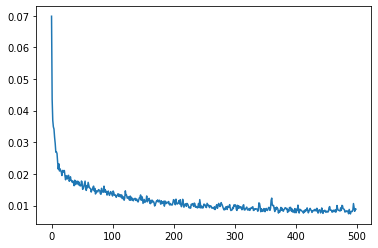

In [ ]:
plt.plot(loss_)
plt.show()

In [ ]:
def evaluation(dataloader):

    predictions = torch.tensor([], dtype=torch.float)
    actual = torch.tensor([], dtype=torch.float)

    with torch.no_grad():
        model.eval()    # 평가 시 드랍아웃을 비활성화
        for data in dataloader:
            inputs, values = data
            outputs = model(inputs)

            predictions = torch.cat((predictions, outputs), 0)
            actual = torch.cat((actual, values), 0)

    predictions = predictions.numpy()
    actual = actual.numpy()
    rmse = np.sqrt(mean_squared_error(predictions, actual))

    return rmse

In [ ]:
train_rmse = evaluation(trainloader)
test_rmse = evaluation(testloader)

print('Train RMSE: ', train_rmse)
print('Test RMSE: ', test_rmse)

Train RMSE:  0.033553172
Test RMSE:  0.07120262


In [ ]:
# Multithreaded Local Learning Regularization Neural Networks for Regression Tasks, 2015

print('RMSE: 0.08019')

RMSE: 0.08019
